# Link Level Simulation for Physical Downlink Shared Channel in 5G

**Key Performance Parameters**
- Throughput vs SNR
- BLER vs SNR


## Import Python Libraries

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

## Import 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../../")

from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy
from toolkit5G.ChannelModels          import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.Configurations         import PDSCHLowerPhyConfiguration, PDSCHUpperPhyConfiguration
from toolkit5G.ChannelProcessing      import AddNoise, ApplyChannel
from toolkit5G.SymbolMapping          import Mapper, Demapper

## Simulation Parameters

In [3]:

carrierFrequency = 3.6*10**9 # Carrier Frequency
numBatches   = 100           # Number of batches considered for simulation
scs          = 30*10**3      # Subcarrier Spacing for simulation
numBSs       = 1             # Number of BSs considered for simulation
# Number of UEs considered for simulation
numUEs       = numBatches    # For now we are assuming that the numbatches are captured via numUEs
numRB        = 85            # Number of Resource mapping considered for simulation | # 1 RB = 12 subcarrier
Nfft         = 1024          # FFTSize
slotNumber   = 0             # Index of the slot considered for simulation
terrain      = "CDL-A"         # Terrain

txAntStruture = np.array([1,1,4,4,2]) # Tx Antenna Structure
rxAntStruture = np.array([1,1,1,2,2]) # Rx Antenna Structure

print("************ Simulation Parameters *************")
print()
print("     numBatches: "+str(numBatches))
print("          numRB: "+str(numRB))
print("       fft Size: "+str(Nfft))
print("         numBSs: "+str(numBSs))
print("         numUEs: "+str(numUEs))
print("            scs: "+str(scs))
print("     slotNumber: "+str(slotNumber))
print("        terrain: "+str(terrain))
print("Tx Ant Struture: "+str(txAntStruture))
print("Rx Ant Struture: "+str(rxAntStruture))
print()
print("********************************************")

************ Simulation Parameters *************

     numBatches: 100
          numRB: 85
       fft Size: 1024
         numBSs: 1
         numUEs: 100
            scs: 30000
     slotNumber: 0
        terrain: CDL-A
Tx Ant Struture: [1 1 4 4 2]
Rx Ant Struture: [1 1 1 2 2]

********************************************


## Generate Channel

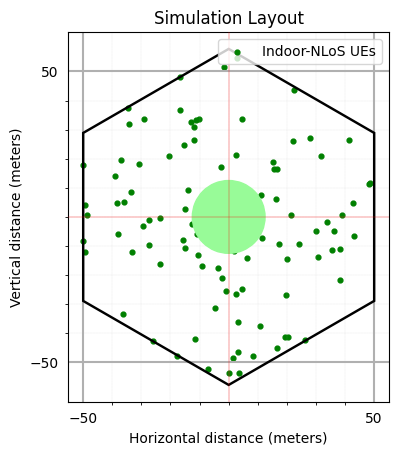

             Number of BSs: 1
          Shape of Channel: (1, 1, 1, 100, 1024, 4, 32)
*****************************************************



In [4]:
# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, 
                           arrayStructure  = rxAntStruture)
ueAntArray()

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency,
                           arrayStructure  = txAntStruture)
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 100         # inter site distance
minDist              = 10          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 1           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
# forceLOS             = True       # boolen flag if true forces every link to be in LOS state
forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = numBSs,
                                numOfUE = numUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = terrain, 
             carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()

paramGen = simLayoutObj.getParameterGenerator()

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft, normalizeChannel = True)

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

print("             Number of BSs: "+str(numBSs))
print("          Shape of Channel: "+str(Hf.shape))
print("*****************************************************")
print()

## PDSCH Configurations

In [5]:
########################################## PDSCH Lower Physical Layer Parameters #########################################
pdschLowerPhyConfig    = PDSCHLowerPhyConfiguration(rank = 1, startSymbol=2, numSymbols=12, pdschMappingType = "PDSCH-mapping-type-A", 
                                                    maxLength = "len1", dmrsAdditionalPosition = "pos0", l0 = 0,
                                                    configurationType = "Configuration-type-1")
pdschMappingType       = pdschLowerPhyConfig.pdschMappingType   # "PDSCH mapping type A" or "PDSCH mapping type B"
maxLength              = pdschLowerPhyConfig.maxLength
startSymbol            = pdschLowerPhyConfig.startSymbol
numSymbols             = pdschLowerPhyConfig.numSymbols
betaDMRS               = pdschLowerPhyConfig.betaDMRS
configurationType      = pdschLowerPhyConfig.configurationType   # "Configuration-type-1" or "Configuration-type-2"
dmrsTypeAPosition      = pdschLowerPhyConfig.dmrsTypeAPosition                                   # "pos2" or "pos3"
dmrsAdditionalPosition = pdschLowerPhyConfig.dmrsAdditionalPosition  # "pos2" or "pos3"
ld                     = pdschLowerPhyConfig.ld
l0                     = pdschLowerPhyConfig.l0
l1                     = pdschLowerPhyConfig.l1
rank                   = pdschLowerPhyConfig.rank
scramblingID           = pdschLowerPhyConfig.scramblingID
nSCID                  = pdschLowerPhyConfig.nSCID

mcsIndex               = 7
mcsTable               = "pdschTable1"

########################################## PDSCH Parameters #########################################
pdschUpperPhyConfig    = PDSCHUpperPhyConfiguration(pdschMappingType = pdschMappingType, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, maxLength = maxLength, mcsIndex = mcsIndex,
                                                    mcsTable = mcsTable, dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                    ld = ld, l1 = l1, startSymbol = startSymbol, numSymbols = numSymbols, rank = rank, 
                                                    numRB = numRB)

numTBs                 = pdschUpperPhyConfig.numTBs
numRB                  = pdschUpperPhyConfig.numRB
tbLen1                 = pdschUpperPhyConfig.tbLen1

codeRate               = pdschUpperPhyConfig.codeRate
modOrder               = pdschUpperPhyConfig.modOrder
mcsIndex               = pdschUpperPhyConfig.mcsIndex
mcsTable               = pdschUpperPhyConfig.mcsTable
numlayers              = pdschUpperPhyConfig.numlayers
scalingField           = pdschUpperPhyConfig.scalingField
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead
dmrsREs                = pdschUpperPhyConfig.dmrsREs
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead

numTargetBits1         = pdschUpperPhyConfig.numTargetBits1
if(numTBs == 2):
    numTargetBits1     = pdschUpperPhyConfig.numTargetBits1
    numTargetBits2     = pdschUpperPhyConfig.numTargetBits2
    tbLen2             = pdschUpperPhyConfig.tbLen2

numTargetBits          = pdschUpperPhyConfig.numTargetBits

************ PDSCH Parameters *************

       pdschMappingType: PDSCH-mapping-type-A
            startSymbol: 2
             numSymbols: 12
               betaDMRS: 1
                   rank: 1
      configurationType: Configuration-type-1
              maxLength: len1
      dmrsTypeAPosition: pos2
 dmrsAdditionalPosition: pos0
           Duration, ld: 12
       Start symbol, l0: 0
     Start symbol-1, l1: 11
          num of Layers: 1

********************************************
********************************************
          tbsize-1: 12040

            numTBs: 1
            numCBs: 2
         numLayers: 1 | LayerperTB: [1 0]
             numRB: 85
          coderate: 0.513671875
          modOrder: 2
additionalOverhead: 0
numberTargetBits: 23460
********************************************


## PDSCH Implementation
This section implements implements both
- Upper Physical layer
- Lower Physical layer

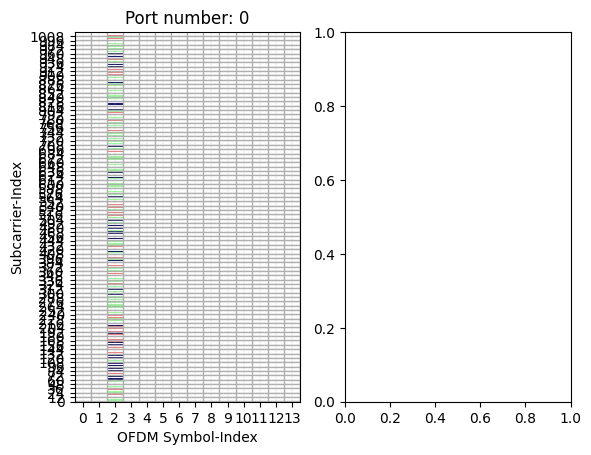

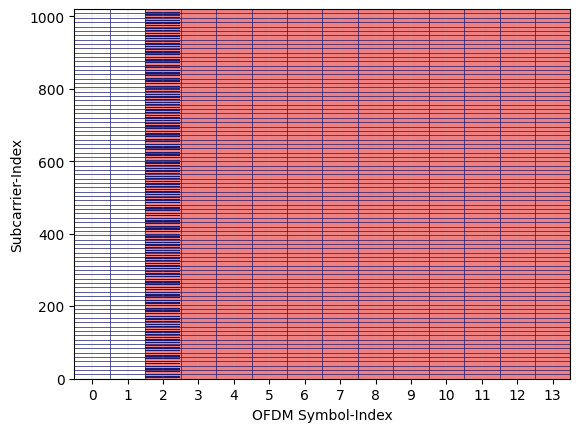

In [6]:

pdschUpperPhy = PDSCHUpperPhy(symbolsPerSlot = numSymbols, numRB = numRB, mcsIndex = mcsIndex, 
                              numlayers = numlayers, scalingField = scalingField, 
                              additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                              numTBs=numTBs, pdschTable = mcsTable, verbose = False)

codeword      = pdschUpperPhy(tblock = [None, None], rvid = [0, 0], enableLBRM = [False, False], 
                              numBatch = numBatches, numBSs = numBSs)

rnti         = np.random.randint(65536, size=numBSs*numBatches)
nID          = np.random.randint(1024,  size=numBSs*numBatches)
bits2        = codeword[1] if numTBs == 2 else None

pdschLowerPhyChain = PDSCHLowerPhy(pdschMappingType, configurationType, dmrsTypeAPosition, 
                                   maxLength, dmrsAdditionalPosition, l0, ld, l1)
resourceGrid  = pdschLowerPhyChain(codeword[0], numRB, rank, slotNumber, scramblingID, 
                                        nSCID, rnti, nID, modOrder, startSymbol, bits2 = bits2)

## Load the resource Grid into the transmision Grid
txGrid        = np.zeros(resourceGrid.shape[0:-1]+(Nfft,), dtype= np.complex64)
bwpOffset     = np.random.randint(Nfft-numRB*12)
txGrid[...,bwpOffset:bwpOffset+numRB*12] = resourceGrid

fig, ax   = pdschLowerPhyChain.displayDMRSGrid()
pdschLowerPhyChain.displayResourceGrid()

## SVD based Precoding and Beamforming

In [7]:
txGrid.shape

(100, 1, 1, 14, 1024)

In [8]:
# Digital Beamforming
[U, S, Vh] = np.linalg.svd(Hf)
precoder   = np.conj(Vh.transpose(3,0,1,2,4,6,5)[...,0:rank])
combiner   = np.conj((U*(1/S[...,np.newaxis,:].repeat(S.shape[-1], axis = -2)))[...,0:rank].transpose(3,0,1,2,4,6,5))
xBeam      = (precoder@txGrid.transpose(0,1,3,4,2)[:,np.newaxis,...,np.newaxis])[...,0]

print("************ Beamforming Parameters *************")
print()
print("    Precoder Shape: "+str(precoder.shape))
print("    Combiner Shape: "+str(combiner.shape))
print("     Channel Shape: "+str(Hf.shape))
print("Eigen Matrix Shape: "+str(S.shape))
print("Beamformed Grid sh: "+str(xBeam.shape))
print()
print("********************************************")

************ Beamforming Parameters *************

    Precoder Shape: (100, 1, 1, 1, 1024, 32, 1)
    Combiner Shape: (100, 1, 1, 1, 1024, 1, 4)
     Channel Shape: (1, 1, 1, 100, 1024, 4, 32)
Eigen Matrix Shape: (1, 1, 1, 100, 1024, 4)
Beamformed Grid sh: (100, 1, 1, 14, 1024, 32)

********************************************


## Pass through the Wireless Channel

In [9]:
# Channel Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots), numBSs, numUEs, numSamples/numFFTpoints, numRxAntennas, numTxAntennas
# Tx-Grid Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots), numBSs,         numSamples/numFFTpoints,                numTxAntennas
# Rx-Grid Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots),   --    numUEs, numSamples/numFFTpoints, numRxAntennas

ptc = ApplyChannel(isFrequencyDomain = True, enableInterTxInterference = True, memoryConsumptionLevel = 0)
y   = ptc(Hf[np.newaxis].transpose(4,0,1,2,3,5,6,7), xBeam.transpose(0,1,3,2,4,5))

print("************ Channel Parameters *************")
print()
print("      Channel Shape: "+str(Hf.shape))
print("Received Grid shape: "+str(y.shape))
print(" Beamformed Grid sh: "+str(xBeam.shape))
print()
print("********************************************")

************ Channel Parameters *************

      Channel Shape: (1, 1, 1, 100, 1024, 4, 32)
Received Grid shape: (100, 1, 14, 1, 1024, 4)
 Beamformed Grid sh: (100, 1, 1, 14, 1024, 32)

********************************************


## Recevier Side Processing

In [10]:
numPoints  = 10
SNRdB      = np.linspace(-11, -2, numPoints, endpoint=True)
# SNRdB      = np.linspace(-13.5, -7.5, numPoints, endpoint=True)
SNR        = 10**(SNRdB/10)

codedBER   = np.zeros(numPoints)
uncodedBER = np.zeros(numPoints)
bler       = np.zeros(numPoints)
throughput = np.zeros(numPoints)

for i in range(numPoints):
    print("********************************************************")
    print("Simulation: ["+str(i)+"] for      SNRdB = "+str(SNRdB[i]))
    
    ## Add noise to the received grid
    yGrid = AddNoise(False)(y, 1/SNR[i], 0)

    ## Receiver Combining
    rGrid = ((combiner@yGrid[...,np.newaxis])[:,0,...,0]).transpose(0,2,4,1,3)

    ## Extracting the Received Grid
    rxGrid = rGrid[...,bwpOffset:bwpOffset+12*numRB]

    ## Receiver: Lower Physical layer
    isChannelPerfect = False
    pdschDecLowerPhy = PDSCHDecoderLowerPhy(modOrder, isChannelPerfect, isEqualized = True)
    descrBits        = pdschDecLowerPhy(rxGrid, pdschLowerPhyChain.pdschIndices, rnti, 
                                        nID, SNR[i], None, numTBs, hard_out = False)

    ## Receiver: Upper Physical layer
    pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols, 
                                         numRB = numRB, numLayers = numlayers, scalingField = scalingField, 
                                         additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                                         enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)

    bits          = pdschUpPhyDec(descrBits)

    ## KPI computation
    codedBER[i]   = np.mean(np.abs(bits-pdschUpperPhy.tblock1))
    uncodedBER[i] = np.mean(np.abs(codeword[0] - np.where(descrBits[0]>0,1,0)))
    bler[i]       = 1-np.mean(pdschUpPhyDec.crcCheckforCBs)
    throughput[i] = (1-bler[i])*tbLen1*2000
    
    print("Simulation: ["+str(i)+"] for   codedBER = "+str(codedBER[i]))
    print("Simulation: ["+str(i)+"] for uncodedBER = "+str(uncodedBER[i]))
    print("Simulation: ["+str(i)+"] for       BLER = "+str(bler[i]))
    print("Simulation: ["+str(i)+"] for Throughput = "+str(throughput[i]))
    
    print("********************************************************")
    print()

********************************************************
Simulation: [0] for      SNRdB = -11.0
Simulation: [0] for   codedBER = 0.009053156146179402
Simulation: [0] for uncodedBER = 0.009252344416027281
Simulation: [0] for       BLER = 1.0
Simulation: [0] for Throughput = 0.0
********************************************************

********************************************************
Simulation: [1] for      SNRdB = -10.0
Simulation: [1] for   codedBER = 0.004455980066445183
Simulation: [1] for uncodedBER = 0.004647485080988918
Simulation: [1] for       BLER = 1.0
Simulation: [1] for Throughput = 0.0
********************************************************

********************************************************
Simulation: [2] for      SNRdB = -9.0
Simulation: [2] for   codedBER = 0.0018064784053156147
Simulation: [2] for uncodedBER = 0.0019855072463768114
Simulation: [2] for       BLER = 1.0
Simulation: [2] for Throughput = 0.0
*************************************************

## Simulation Results

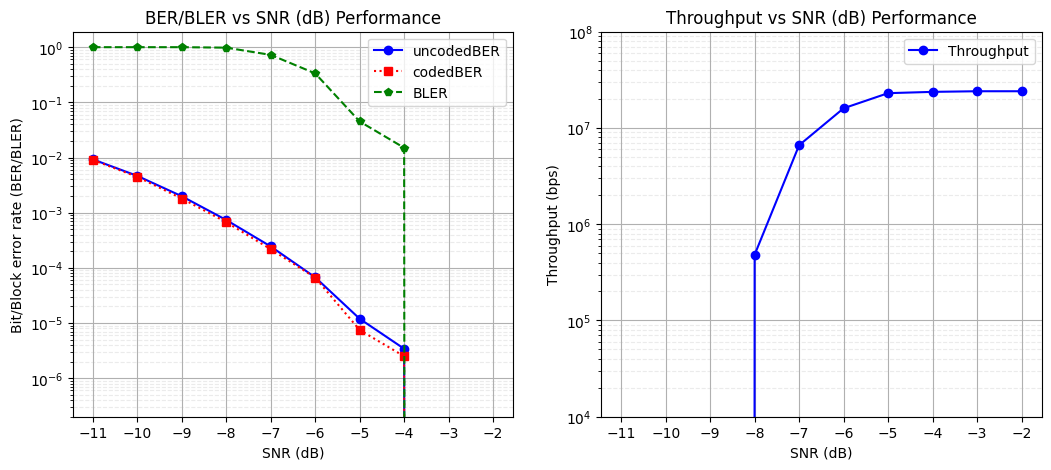

In [11]:
fig, ax = plt.subplots(1,2, figsize = (12.5, 5))

ax[0].semilogy(SNRdB, uncodedBER, "-b", marker = "o", label="uncodedBER")
ax[0].semilogy(SNRdB, codedBER,   ":r", marker = "s", label="codedBER")
ax[0].semilogy(SNRdB, bler,      "--g", marker = "p", label="BLER")
ax[0].legend(loc="best")

ax[0].set_xticks(SNRdB)
ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax[0].set_yticks(ytck, minor=True)
ax[0].set_yticks(0.1**(np.arange(0, 7)), minor=False)

ax[0].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[0].grid(which = 'major', alpha = 1)

ax[0].set_xlabel("SNR (dB)")
ax[0].set_ylabel("Bit/Block error rate (BER/BLER)")
ax[0].set_title("BER/BLER vs SNR (dB) Performance")

ax[1].semilogy(SNRdB, throughput, "-b", marker = "o", label="Throughput")
ax[1].legend(loc="best")

ax[1].set_xticks(SNRdB, minor=False)
ytck = 10**(np.arange(4, 9)).repeat(9)*np.tile(np.arange(1, 10), [5])
ax[1].set_yticks(ytck, minor=True)
ax[1].set_yticks(10**(np.arange(4, 8)), minor=False)
ax[1].set_ylim([10**4, 10**8])
ax[1].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[1].grid(which = 'major', alpha = 1)

ax[1].set_xlabel("SNR (dB)")
ax[1].set_ylabel("Throughput (bps)")
ax[1].set_title("Throughput vs SNR (dB) Performance")

plt.show()

## Simulation Results: Averaged over 10000 batches

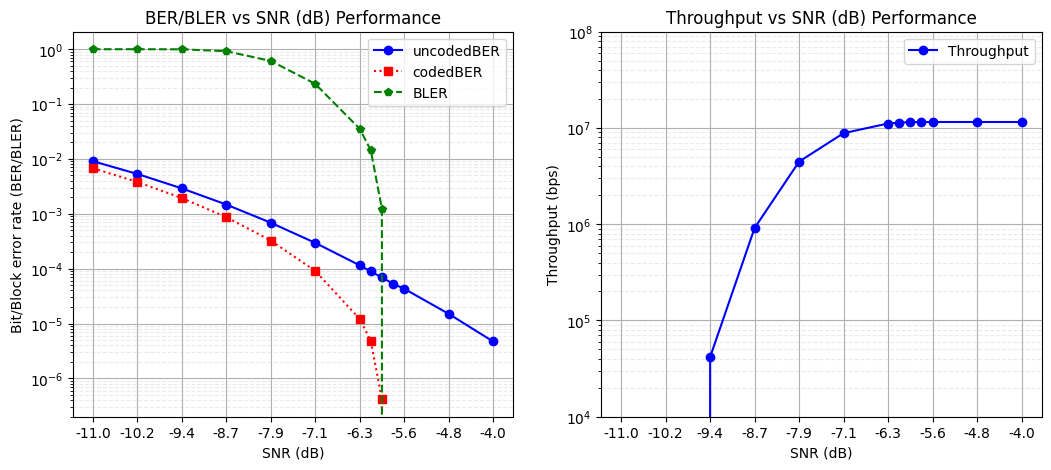

In [14]:
from matplotlib.ticker import FormatStrFormatter

filename   = "PDSCH-mcsIndex3-rank-1-dB.npz"
dB         = np.load(filename)
SNRdB      = dB["SNRdB"]
uncodedBER = dB["uncodedBER"]
codedBER   = dB["codedBER"]
bler       = dB["bler"]
throughput = dB["throughput"]
xticks     = np.linspace(-11, -4, 10)

fig, ax = plt.subplots(1,2, figsize = (12.5, 5))

ax[0].semilogy(SNRdB, uncodedBER, "-b", marker = "o", label="uncodedBER")
ax[0].semilogy(SNRdB, codedBER,   ":r", marker = "s", label="codedBER")
ax[0].semilogy(SNRdB, bler,      "--g", marker = "p", label="BLER")
ax[0].legend(loc="best")

ax[0].set_xticks(xticks)
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax[0].set_yticks(ytck, minor=True)
ax[0].set_yticks(0.1**(np.arange(0, 7)), minor=False)

ax[0].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[0].grid(which = 'major', alpha = 1)

ax[0].set_xlabel("SNR (dB)")
ax[0].set_ylabel("Bit/Block error rate (BER/BLER)")
ax[0].set_title("BER/BLER vs SNR (dB) Performance")

ax[1].semilogy(SNRdB, throughput, "-b", marker = "o", label="Throughput")
ax[1].legend(loc="best")

ax[1].set_xticks(xticks, minor=False)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ytck = 10**(np.arange(4, 9)).repeat(9)*np.tile(np.arange(1, 10), [5])
ax[1].set_yticks(ytck, minor=True)
ax[1].set_yticks(10**(np.arange(4, 8)), minor=False)
ax[1].set_ylim([10**4, 10**8])
ax[1].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[1].grid(which = 'major', alpha = 1)

ax[1].set_xlabel("SNR (dB)")
ax[1].set_ylabel("Throughput (bps)")
ax[1].set_title("Throughput vs SNR (dB) Performance")

plt.show()

## Save Results